In [1]:
import folium
from folium.plugins import HeatMap
import pandas as pd
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import branca
from branca.colormap import LinearColormap, StepColormap
import branca.colormap as cm

In [2]:
# Load data
df = pd.read_csv('Resources/volcano-events.csv')

In [3]:
# Create the map
m = folium.Map(location=[0, 0], zoom_start=2)

In [4]:
### cleaning the data

    # selecting the columns of interest
columns_of_interest = ['Year', 'Latitude', 'Longitude', 'VEI', 'Total Deaths', 'Total Damage ($Mil)', 'Total Houses Destroyed']
df_filtered = df[columns_of_interest]

    # drop rows with missing values to ensure data integrity for visualization
df_clean = df_filtered.dropna(subset=['Latitude', 'Longitude', 'VEI', 'Year'])

    # filling missing values with 0 instead of NaN
df_clean.fillna({'Total Deaths': 0, 'Total Damage ($Mil)': 0, 'Total Houses Destroyed': 0}, inplace=True)

C:\Users\mcayt\AppData\Local\Temp\ipykernel_38448\3042257367.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.fillna({'Total Deaths': 0, 'Total Damage ($Mil)': 0, 'Total Houses Destroyed': 0}, inplace=True)


In [5]:
### initial setup for each map 

    # creating the map and centering it
center_lat = df_clean['Latitude'].mean()
center_lon = df_clean['Longitude'].mean()
folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=2)

The lower bound is 1519.125. The years before this could be outliers
The upper bound is 2266.125. The years after this could be outliers


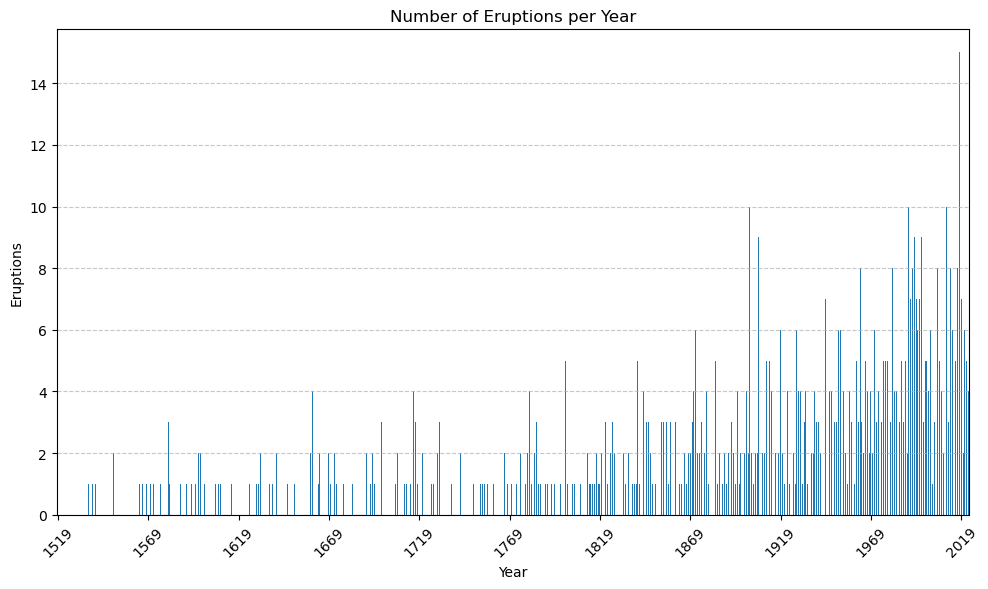

In [6]:
## Timeline

#Determine if there are outliers
quartiles = df_filtered["Year"].quantile([0.25,0.5,0.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
lower_bound = lowerq - (1.5*iqr)
#Print the outliers as to know which years to graph to get the most out of our data
print(f'The lower bound is {lower_bound}. The years before this could be outliers')
upper_bound = upperq + (1.5*iqr)
print(f'The upper bound is {upper_bound}. The years after this could be outliers')
#Create a new series to include years that had no volcanic eruptions, as to not skew the visual of the bar graph
all_years = pd.Series(range(int(df_filtered['Year'].min()), int(df_filtered['Year'].max()) + 1), name='Year')
#Get the number of eruptions per year
year_counts = df_filtered['Year'].value_counts()
#Combine with all the years that had zero eruptions
year_counts = year_counts.reindex(all_years, fill_value=0)
#Get the data that was printed
start_year = 1519
end_year = 2024 #Note: we only need to go to the current year, not 2266
#filter the data to only include data points that are not potential outliers
year_counts_subset = year_counts[(year_counts.index >= start_year) & (year_counts.index <= end_year)]
#plot the graph
plt.figure(figsize=(10, 6))
year_counts_subset.plot(kind='bar')
plt.title('Number of Eruptions per Year')
plt.xlabel('Year')
plt.ylabel('Eruptions')
#Remove most of the x-ticks as to not crowd the visuals
plt.xticks(range(0, len(year_counts_subset.index), 50), year_counts_subset.index[::50], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('timeline_visualization.png', format='png', dpi=300)
plt.show()

In [7]:
## Timeline 

# Create a map centered at a specific location
m = folium.Map(location=[0, 0], zoom_start=3)
# convert column to an integer
new_df = df_clean.astype({"Year":'int'})
# get column of interest
values = new_df["Year"]
last_list = new_df['Year'].tolist()
#Create a function to assign different color based on the value of the year
def get_color(x):
    if x < 0: color =  "#FF0000" #Red
    elif (x<500): color = "#FF7F00" #Orange
    elif (x<1000): color = "#FFFF00" #Yellow
    elif (x<1500): color = "#00FF00" #Green
    elif (x<2000): color = "#0000FF" #Blue
    else: color = "#9400D3" #Purple
    return(color)
#itterate through the rows to plot each point
for idx, row in df_clean.iterrows():
    #Value is just the year
    value = row['Year']
    #Use the function to get a color based on the year
    filled_color = get_color(value)
    #Have folium create a new marker for ech row
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                        radius=10,
                        color=None,
                        fill=True,
                        fill_color=filled_color,
                        # fill_color = colormap(filled_color),
                        fill_opacity =1,
                        popup=f"Year: {value}").add_to(m)
#Create a legend by adding colors and using the list
custom_colors = ["#FF0000","#FF7F00", "#FFFF00", "#00FF00","#9400D3"]
colormap = cm.LinearColormap(colors=custom_colors,
                             index=[0, 500, 1000, 1500, 2023], #Note: -4360 was removed as to not skew the spectrum
                             vmin = 0, vmax=2023)
colormap.caption = 'Year Color spectrum'
colormap.add_to(m)
m.save('history_map.html')

In [8]:
## VEI Map 

center_lat, center_lon = 0, 0 

# defining grades for VEI
def vei_to_color(vei):
    if vei <= 1:
        return '#ffffb2'
    elif vei == 2:
        return '#fecc5c'
    elif vei == 3:
        return '#fd8d3c'
    elif vei == 4:
        return '#f03b20'
    elif vei >= 5:
        return '#bd0026'
    else:
        return '#grey'  # Fallback for any unexpected VEI values

# creating a new Folium map for VEI
m_vei_grad = folium.Map(location=[center_lat, center_lon], zoom_start=2)

# adding a layer for VEI with color gradient onto the map
for index, row in df_clean.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=vei_to_color(row['VEI']),
        fill=True,
        fill_color=vei_to_color(row['VEI']),
        fill_opacity=0.7,
        popup=f"VEI: {row['VEI']}"
    ).add_to(m_vei_grad)

# creating a colormap
color_scale = LinearColormap(colors=['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026'], vmin=0, vmax=7)
color_scale.caption = 'VEI Scale'
color_scale.add_to(m_vei_grad)

# saving the map to an HTML file
m_vei_grad.save("vei_map.html")


In [9]:
##Deaths Map
# Extract latitude, longitude, and death information from the DataFrame
death_counts = df_clean[['Latitude', 'Longitude', 'Total Deaths']].values.tolist()
# Create a map centered at (0,0) with a zoom level of 2
m = folium.Map(location=[0, 0], zoom_start=2)
# Group death counts in each event and add markers
for event in death_counts:
    latitude, longitude, deaths = event
    # Determine color based on number of deaths
    if deaths == 0:
        color = "blue"
    elif deaths <= 10:
        color = "green"
    elif 11 <= deaths <= 50:
        color = "yellow"
    elif 51 <= deaths <= 100:
        color = "orange"
    else:
        color = "red"
    # Add markers to map
    popup_content = f"Total Deaths: {deaths}"
    folium.CircleMarker(location=[latitude, longitude], radius=5, color=color, fill=True, fill_color=color, fill_opacity=0.6, weight=0, popup=popup_content).add_to(m)
# Create a colormap
color_scale = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange'], vmin=0, vmax=100)
color_scale.caption = 'Casualties by Volcanic Event'
# Add color for values above 100
color_scale.add_to(m)
# Add a color for values above 100
m.add_child(cm.StepColormap(['red'], vmin=100, vmax=max([event[2] for event in death_counts])))
# Save the map to an HTML file
m.save("death_map.html")

In [10]:
##Damages Map 
# Extract latitude, longitude, and deaths information from the DataFrame
top_damage_events = df_clean[['Latitude', 'Longitude', 'Total Deaths']].values.tolist() 

#columns_of_interest = ['Latitude', 'Longitude', 'VEI', 'Total Deaths', 'Total Damage ($Mil)', 'Total Houses Destroyed']
#df_filtered = df[columns_of_interest]
df_sorted = df_clean.sort_values(by='Total Damage ($Mil)', ascending=False)

# Select the first ten rows from the sorted DataFrame
df_top_10_damage = df_sorted.head(10)

# Display the new DataFrame containing the top ten data points with the most damage
print(df_top_10_damage)

# Assuming df_top_10_damage is your DataFrame containing the top 10 data points with the most damage
# Extract latitude, longitude, and total damage information from the DataFrame
top_damage_events = df_top_10_damage[['Latitude', 'Longitude', 'Total Damage ($Mil)', 'Total Houses Destroyed']].values.tolist()
# Create a map centered at (0,0) with a zoom level of 2
m = folium.Map(location=[0, 0], zoom_start=2)
# Add markers for top damage events with custom HTML fire icon
for event in top_damage_events:
    popup_content = f"<i class='fas fa-fire' style='color:red; font-size:24px;'></i><br>Total Damage ($Mil): {event[2]}<br>Total Houses Destroyed: {event[3]}"
    folium.Marker(location=[event[0], event[1]],
                  popup=popup_content,
                  icon=folium.Icon(color='red', icon='')).add_to(m)
# Extract heatmap data
heatmap_data = [[event[0], event[1], event[2]] for event in top_damage_events]
# Create a heatmap layer
gradient = {.01: 'orange', .05: 'yellow', 1.0: 'red'}
HeatMap(heatmap_data, radius=30, blur=8, max_zoom=20, gradient=gradient).add_to(m)
# Save the map to an HTML file
m.save('latest_map_with_custom_html_icon.html')

       Year  Latitude  Longitude  VEI  Total Deaths  Total Damage ($Mil)  \
628  1980.0    46.200   -122.180  5.0          61.0             2000.000   
866  2021.0    28.570    -17.830  3.0           1.0              900.000   
845  2018.0    19.421   -155.287  1.0           0.0              370.000   
864  2021.0    13.330    -61.180  4.0           0.0              325.000   
851  2018.0    -6.102    105.423  3.0         437.0              250.000   
847  2018.0    14.473    -90.880  2.0         201.0              120.000   
852  2018.0    37.748     14.999  2.0           0.0              115.000   
868  2022.0   -20.536   -175.382  5.0           6.0              107.768   
708  1994.0    -4.271    152.203  3.0           4.0               86.000   
860  2020.0    14.002    120.993  4.0          39.0               67.000   

     Total Houses Destroyed  
628                     0.0  
866                  1345.0  
845                   716.0  
864                     0.0  
851          